### 广告渠道效果分析
在运营中，会进行投放广告获取新客，投放的渠道很多，每个渠道的客户性质也可能不同，效果可能会有差异。现对不同渠道的广告效果进行分析实现有针对性的广告效果测量和优化工作

#### 数据解读
各渠道的日均UV、注册率、搜索率、访问深度、停留时长、转化率、投放时间等，接下来将对渠道进行分类，找到每类渠道的特征，为业务运营提供支持

- 渠道代号：渠道唯一标识
- 日均UV：每天的独立访问量(90天的UV)
- 平均注册率=日均注册用户数/平均每日访问量
- 平均搜索量：每个访问的搜索量
- 访问深度：总页面浏览量/平均每天的访问量
- 平均停留时长=总停留时长/平均每天的访问量
- 订单转化率=总订单数量/平均每天的访客量
- 投放时间：每个广告在外投放的天数
- 素材类型：'jpg' 'swf' 'gif' 'sp'
- 广告类型：banner、tips、不确定、横幅、暂停
- 合作方式：'roi' 'cpc' 'cpm' 'cpd'
- 广告尺寸：'140*40' '308*388' '450*300' '600*90' '480*360'等
- 广告卖点：打折、满减、满赠、秒杀、直降、满返

In [1]:
# 数据预处理
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import silhouette_score    # 导入轮廓系数指标
from sklearn.cluster import KMeans
import warnings
%matplotlib inline

# 设置图表中文字属性，防止中文乱码
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
plt.rcParams['axes.unicode_minus'] = False

# 忽略警告
warnings.filterwarnings('ignore')

In [2]:
ad_rawdata = pd.read_csv('../00_dataset/ad_performance_data.csv')
# ad_rawdata = pd.read_csv('../00_dataset/ad_performance.txt', delimiter='\t')
ad_rawdata.head()

,渠道代号,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间,素材类型,广告类型,合作方式,广告尺寸,广告卖点
0,A203,3.69,0.0071,0.0214,2.3071,419.77,0.0258,20,jpg,banner,roi,140*40,打折
1,A387,178.70,0.0040,0.0324,2.0489,157.94,0.0030,19,jpg,banner,cpc,140*40,满减
2,A388,91.77,0.0022,0.0530,1.8771,357.93,0.0026,4,jpg,banner,cpc,140*40,满减
3,A389,1.09,0.0074,0.3382,4.2426,364.07,0.0153,10,jpg,banner,cpc,140*40,满减
4,A390,3.37,0.0028,0.1740,2.1934,313.34,0.0007,30,jpg,banner,cpc,140*40,满减


In [8]:
ad_rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   渠道代号    889 non-null    object 
 1   日均UV    889 non-null    float64
 2   平均注册率   889 non-null    float64
 3   平均搜索量   889 non-null    float64
 4   访问深度    889 non-null    float64
 5   平均停留时间  887 non-null    float64
 6   订单转化率   889 non-null    float64
 7   投放总时间   889 non-null    int64  
 8   素材类型    889 non-null    object 
 9   广告类型    889 non-null    object 
 10  合作方式    889 non-null    object 
 11  广告尺寸    889 non-null    object 
 12  广告卖点    889 non-null    object 
dtypes: float64(6), int64(1), object(6)
memory usage: 90.4+ KB


In [9]:
ad_rawdata.describe()

,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间
count,889.000000,889.000000,889.000000,889.000000,887.000000,889.000000,889.000000
mean,540.846772,0.001408,0.030493,2.167166,262.669188,0.002852,16.052868
std,1634.410463,0.003291,0.106199,3.800528,224.364932,0.011608,8.509435
min,0.060000,0.000000,0.000000,1.000000,1.640000,0.000000,1.000000
25%,6.180000,0.000000,0.000600,1.392300,126.020000,0.000000,9.000000
50%,114.180000,0.000000,0.003200,1.793100,236.550000,0.000200,16.000000
75%,466.870000,0.001400,0.011800,2.216200,357.985000,0.002000,24.000000
max,25294.770000,0.039100,1.037000,98.979900,4450.830000,0.216500,30.000000


In [11]:
ad_rawdata.isnull().sum().sort_values(ascending=False)

平均停留时间    2
广告卖点      0
广告尺寸      0
合作方式      0
广告类型      0
素材类型      0
投放总时间     0
订单转化率     0
访问深度      0
平均搜索量     0
平均注册率     0
日均UV      0
渠道代号      0
dtype: int64

********************Correction Analysis:********************
          日均UV   平均注册率   平均搜索量    访问深度  平均停留时间   订单转化率   投放总时间
日均UV    1.0000 -0.0512 -0.0735 -0.0217  0.0351 -0.0452 -0.0385
平均注册率  -0.0512  1.0000  0.2381  0.1063  0.2203  0.3166 -0.0141
平均搜索量  -0.0735  0.2381  1.0000  0.0631  0.1651  0.1259 -0.0268
访问深度   -0.0217  0.1063  0.0631  1.0000  0.7247  0.1637  0.0575
平均停留时间  0.0351  0.2203  0.1651  0.7247  1.0000  0.2530  0.0471
订单转化率  -0.0452  0.3166  0.1259  0.1637  0.2530  1.0000 -0.0046
投放总时间  -0.0385 -0.0141 -0.0268  0.0575  0.0471 -0.0046  1.0000


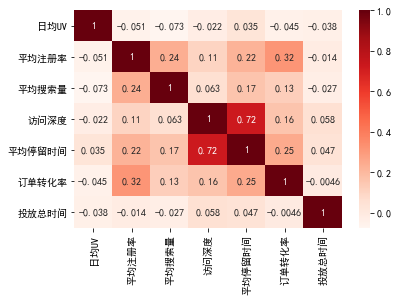

In [21]:
# 相关性分析
print("{:*^60}".format("Correction Analysis:"))
print(ad_rawdata.corr().round(4).T)    # 使用皮尔逊系数查看相关性

# 以热力图的形式展现特征的相关性
ad_corr = ad_rawdata.corr().round(4)
sns.heatmap(ad_corr, cmap='Reds', annot=True)

从相关性系数和热力图中，可以看到“访问深度”和“平均停留时间”的相关系数为0.72，属于高度相关，表明二者在模型中的作用效果一样，因此在建模中可以考虑**组合**或**删除其一**

In [27]:
# 数据处理
ad_data = ad_rawdata.drop(['平均停留时间'], axis=1)

# 对类别变量进行处理
category_cols = ['素材类型', '广告类型', '合作方式', '广告尺寸', '广告卖点']
for i in category_cols:
    data_tmp = ad_data[i].unique()
    print("变量【{0}】的取值有： \n{1}".format(i, data_tmp))
    print("-."*20)

变量【素材类型】的取值有： 
['jpg' 'swf' 'gif' 'sp']
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
变量【广告类型】的取值有： 
['banner' 'tips' '不确定' '横幅' '暂停']
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
变量【合作方式】的取值有： 
['roi' 'cpc' 'cpm' 'cpd']
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
变量【广告尺寸】的取值有： 
['140*40' '308*388' '450*300' '600*90' '480*360' '960*126' '900*120'
 '390*270']
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
变量【广告卖点】的取值有： 
['打折' '满减' '满赠' '秒杀' '直降' '满返']
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.


In [53]:
# 对类别变量OneHotEncoder编码
feature_ohe = OneHotEncoder(sparse=False)    # 建立OneHotEncode对象
matrix_ohe = feature_ohe.fit_transform(ad_data[category_cols])    # 训练数据
print("对类别变量OneHotEncoder编码")
matrix_ohe = pd.get_dummies(ad_data[category_cols])
df_ohe = matrix_ohe.copy()
df_ohe['渠道代号'] = ad_rawdata['渠道代号']
# 将渠道代号列移到第一列
df_chn = df_ohe['渠道代号']
df_ohe = df_ohe.drop('渠道代号', axis=1)
df_ohe.insert(0, '渠道代号', df_chn)
df_ohe.to_csv("类别变量OneHotEncoder编码.csv", index=0)
df_ohe.head()

对类别变量OneHotEncoder编码


,渠道代号,素材类型_gif,素材类型_jpg,素材类型_sp,素材类型_swf,广告类型_banner,广告类型_tips,广告类型_不确定,广告类型_暂停,广告类型_横幅,...,广告尺寸_480*360,广告尺寸_600*90,广告尺寸_900*120,广告尺寸_960*126,广告卖点_打折,广告卖点_满减,广告卖点_满赠,广告卖点_满返,广告卖点_直降,广告卖点_秒杀
0,A203,0,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,A387,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,A388,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,A389,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,A390,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [52]:
# 数据标准化
scale_matrix = ad_data.iloc[:, 1:7]    # 对连续性变量进行标准化
model_scaler = MinMaxScaler()
data_scaled = model_scaler.fit_transform(scale_matrix)  
df_scaler = pd.DataFrame(data_scaled.round(4))
df_scaler.columns = ['日均UV', '平均注册率', '平均搜索量', '访问深度', '平均停留时间', '订单转化率']
df_scaler.head()

,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率
0,0.0001,0.1816,0.0206,0.0133,0.1192,0.6552
1,0.0071,0.1023,0.0312,0.0107,0.0139,0.6207
2,0.0036,0.0563,0.0511,0.0090,0.0120,0.1034
3,0.0000,0.1893,0.3261,0.0331,0.0707,0.3103
4,0.0001,0.0716,0.1678,0.0122,0.0032,1.0000


In [54]:
cls_scaler = df_scaler.copy()
cls_scaler['渠道代号'] = ad_rawdata['渠道代号']
columns_order = ['渠道代号', '日均UV', '平均注册率', '平均搜索量', '访问深度', '平均停留时间', '订单转化率']
cls_scaler = cls_scaler[columns_order]
cls_scaler.to_csv("连续型变量-数据标准化.csv", index=0)
cls_scaler.head()

,渠道代号,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率
0,A203,0.0001,0.1816,0.0206,0.0133,0.1192,0.6552
1,A387,0.0071,0.1023,0.0312,0.0107,0.0139,0.6207
2,A388,0.0036,0.0563,0.0511,0.0090,0.0120,0.1034
3,A389,0.0000,0.1893,0.3261,0.0331,0.0707,0.3103
4,A390,0.0001,0.0716,0.1678,0.0122,0.0032,1.0000


In [42]:
# 将处理结果合并
df_result = pd.merge(df_scaler, df_ohe, left_on='渠道代号', right_on='渠道代号', how='inner')
df_result.to_csv("数据处理结果.csv", index=0)
df_result.head()

,渠道代号,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,素材类型_gif,素材类型_jpg,素材类型_sp,...,广告尺寸_480*360,广告尺寸_600*90,广告尺寸_900*120,广告尺寸_960*126,广告卖点_打折,广告卖点_满减,广告卖点_满赠,广告卖点_满返,广告卖点_直降,广告卖点_秒杀
0,A203,0.0001,0.1816,0.0206,0.0133,0.1192,0.6552,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,A387,0.0071,0.1023,0.0312,0.0107,0.0139,0.6207,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,A388,0.0036,0.0563,0.0511,0.0090,0.0120,0.1034,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,A389,0.0000,0.1893,0.3261,0.0331,0.0707,0.3103,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,A390,0.0001,0.0716,0.1678,0.0122,0.0032,1.0000,0,1,0,...,0,0,0,0,0,1,0,0,0,0


### 构建聚类模型，通过平均轮廓系数检验得到最佳KMeans聚类模型 

#### 轮廓系数的思想
最佳的聚类类别划分是从数据特征上看，**类内距离最小化且类别间距离最大化**，直观的理解就是“物以类聚”：同类的聚集抱团，不同类尽量距离远。轮廓系数就是通过枚举K的取值来计算平均轮廓系数，从而得到最佳的K值。
<img src="image.png" style="width:450px;height:300px;float:middle">

- **a(i)**: i向量到同一簇内其他点不相似程度的平均值
- **b(i)**: i向量到其他簇的平均不相似程度的最小值
- 轮廓系数的值介于[-1, 1]，越趋近于1代表内聚度和分离度都相对较优
- 将所有点的轮廓系数求平均，就是该聚类结果总的轮廓系数

In [75]:
# 建模，通过平均轮廓系数检验得到KMeans聚类模型
score_list = []    # 储存每个K下模型的平均轮廓系数
silhouette_int = -1    # 初始化的平均轮廓系数阈值
feature_vectors = np.hstack((df_scaler, matrix_ohe))
for n_cluster in range(2, 8):    
    model_kmeans = KMeans(n_clusters=n_cluster, init='k-means++', random_state=101)    # 建立聚类模型对象
    labels_tmp = model_kmeans.fit_predict(feature_vectors)    # 训练聚类模型
    silhouette_tmp = silhouette_score(feature_vectors, labels_tmp)    # 得到每个K下的平均轮廓系数
    if silhouette_tmp > silhouette_int:
        best_k = n_cluster    # 如果平均轮廓系数高于阈值，将较好的K存储下来
        silhouette_int = silhouette_tmp    # 保存平均轮廓得分
        best_kmeans = model_kmeans    # 保存模型实例对象
        cluster_labels_k = labels_tmp    # 保存聚类标签
    score_list.append([n_cluster, silhouette_tmp])    # 将每个K及其对应的平均轮廓系数得分保存至list中
print("{:*^60}".format("K值对应的轮廓系数："))
print(np.array(score_list))
print("最佳的K值是：{0} \n对应的轮廓系数是：{1}".format(best_k, silhouette_int))

*************************K值对应的轮廓系数：*************************
[[2.         0.38655466]
 [3.         0.45757835]
 [4.         0.50209757]
 [5.         0.48003526]
 [6.         0.47761043]
 [7.         0.50079749]]
最佳的K值是：4 
对应的轮廓系数是：0.502097571353431


In [77]:
# 将score_list存入到txt中
silhouette_file = open('silhouette_result.txt', 'w')
silhouette_file.write("\n **********--------------K值对应的轮廓系数-----------------********** \n")
silhouette_file.write(str(score_list))
silhouette_file.write('\n')
silhouette_file.write("\n 最佳的K值是：{0}".format(best_k))
silhouette_file.write("\n 对应的轮廓系数是：{0}".format(silhouette_int))

28

In [82]:
# 将聚类的标签结果与原数据整合
ad_labels = pd.DataFrame(cluster_labels_k, columns=['聚类标签'])
cluster_ad_data = pd.concat((ad_rawdata, ad_labels), axis=1)  # 将标签和原数据整合
cluster_ad_data.to_csv('聚类结果.csv', index=0)

In [95]:
# 分析每类的数据占比
label_count = cluster_ad_data.groupby('聚类标签')['渠道代号'].count().reset_index()
label_count.columns = ['聚类标签', 'counts']
label_count['percentage'] = (label_count['counts'] / len(cluster_ad_data)).round(4)
label_count

,聚类标签,counts,percentage
0,0,313,0.3521
1,1,154,0.1732
2,2,349,0.3926
3,3,73,0.0821


In [115]:
# 计算各个聚类类别内最显著的特征值
label_features = []
# 从best_k中读取每个标签索引
for line in range(best_k):
    label_data = cluster_ad_data[cluster_ad_data['聚类标签'] == line]
    part1_data = label_data.iloc[:, 1:8]    # 获取数值型数据的特征
    part1_desc = part1_data.describe().round(3)    # 得到数值型特征的描述性统计信息
    merge_data1 = part1_desc.iloc[2, :]    # 得到数值型特征的均值
    
    part2_data = label_data.iloc[:, 8:-1]    # 获取字符串型数据特征
    part2_desc = part2_data.describe(include='all')
    merge_data2 = part2_desc.iloc[2, :]    # 得到字符串型数据特征的众数
    
    merge_line = pd.concat((merge_data1, merge_data2), axis=0)
    merge_line['聚类标签'] = line
    label_features.append(merge_line)

# 输出完整的类别特征信息
label_pd = pd.DataFrame(label_features)
label_statis = pd.merge(label_count, label_pd, left_on='聚类标签', right_on='聚类标签', how='inner')
label_statis.T.to_csv('聚类统计结果.csv')

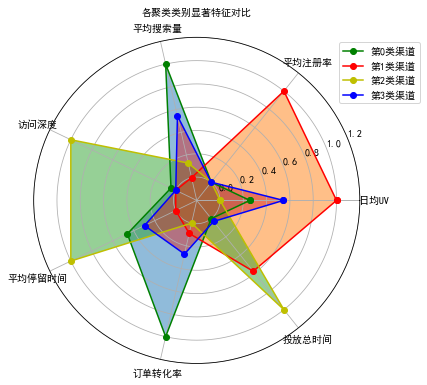

In [139]:
# 对连续型数据采用图表展示
display_data = label_statis.iloc[:, 3:10]
scaler_data = model_scaler.fit_transform(display_data)

# 画图
fig = plt.figure(figsize=(6,6))    # 建立画布
ax = fig.add_subplot(111, polar=True)    # 增加子网格
labels = np.array(merge_data1.index)    # 设置要展示的暑假标签
color_list = ['g', 'r', 'y', 'b']
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)    # 计算各个区间的角度
angles = np.concatenate((angles, [angles[0]]))  # 建立相同首尾字段以便于闭合
# 画雷达图
for i in range(len(display_data)):  # 循环每个类别
    data_tmp = scaler_data[i, :]  # 获得对应类数据
    data = np.concatenate((data_tmp, [data_tmp[0]]))  # 建立相同首尾字段以便于闭合
    ax.plot(angles, data, 'o-', c=color_list[i], label="第%d类渠道"%(i))  # 画线
    ax.fill(angles, data,alpha=2.5)
# 设置图像显示格式
ax.set_thetagrids(angles * 180 / np.pi, labels, fontproperties="SimHei")  # 设置极坐标轴
ax.set_title("各聚类类别显著特征对比", fontproperties="SimHei")  # 设置标题放置
ax.set_rlim(-0.2, 1.2)  # 设置坐标轴尺度范围
plt.legend(loc="upper right" ,bbox_to_anchor=(1.2,1.0))  # 设置图例位置